In [37]:
# Importing all libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm


In [38]:
#Reading input data using pandas library
data = pd.read_csv("day.csv")

In [39]:
#Inspecting data
print(data.shape)
print(data.info())
print(data.isnull().sum())

(730, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None
instant       0
dteday        0
season        0
yr            0
mnth          

In [40]:
#Converting string type to datetype
print(data["dteday"].dtype)
data["dteday"] = data["dteday"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
print(data["dteday"].dtype)

object
datetime64[ns]


In [41]:
#Converting year, seasons and weathersit as per data dictionary
data["yr"] = data["yr"].apply(lambda x: 2018 if x == 0 else 2019)
data["season"] = data["season"].apply(lambda x: str("spring" if x == 1 else "summer" if x == 2 else "fall" if x == 3 else "winter"))
data["weathersit"] = data["weathersit"].apply(lambda x: "clear" if x == 1 else "Mist" if x == 2 else "LightSnow" if x == 3 else "HeavyRain")


In [42]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,spring,2018,1,0,6,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,spring,2018,1,0,0,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,spring,2018,1,0,1,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,spring,2018,1,0,2,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,spring,2018,1,0,3,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [43]:
#Casual + Registered = Cnt, so we should not include registered and casual as predictor variables, 
# but they together constitue target variable and represent two types of demand, one who are registered users who use 
# bike sharing frequently and others are casual users they may have different growth/usage patterns
data[data["cnt"] != data["registered"] + data["casual"]]


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


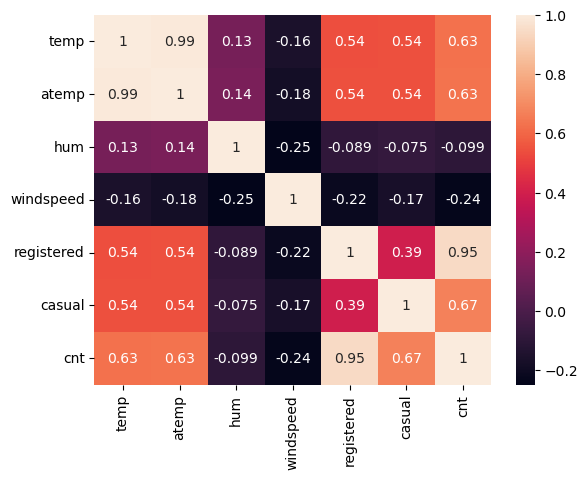

In [44]:
# understand correlation between numeric variables
#num_col = ["yr","mnth","holiday","weekday","workingday","temp","atemp","hum","windspeed"]
num_col = ["temp","atemp","hum","windspeed", "registered","casual","cnt"]
sns.heatmap(data[num_col].corr(), annot=True)
plt.show()
# correlation between temp and atemp is 0.99 so we can drop one of them. we will drop atemp and keep temp

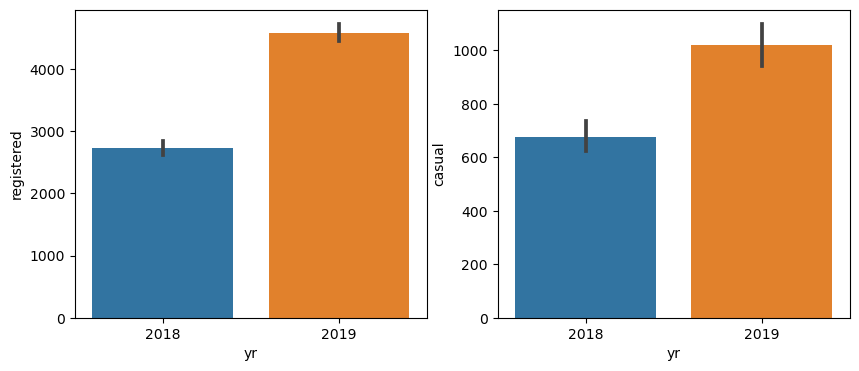

In [45]:
fig,axes = plt.subplots(1,2)
fig.set_size_inches((10,4))
sns.barplot(x=data["yr"],y=data["registered"], ax=axes[0])
sns.barplot(x=data["yr"],y=data["casual"], ax=axes[1])
plt.show()

# both registered and casual usage has increased from 2018 to 2019

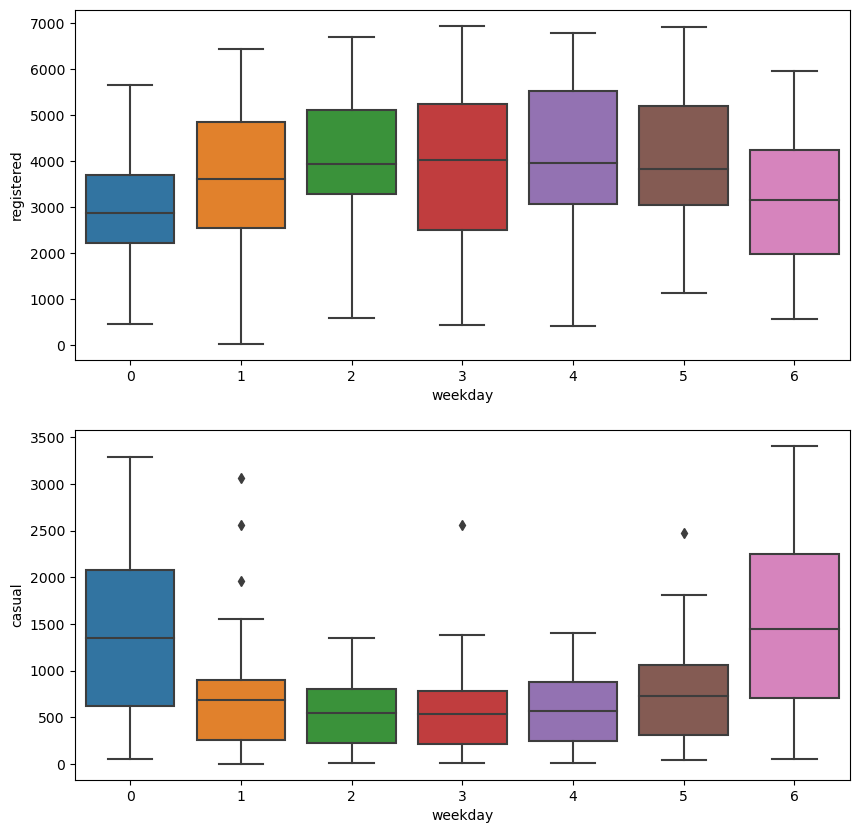

In [46]:
fig,axes = plt.subplots(2,1)
fig.set_size_inches((10,10))
sns.boxplot(x=data["weekday"],y=data["registered"],ax=axes[0])
sns.boxplot(x=data["weekday"],y=data["casual"],ax=axes[1])
plt.show()

# registered usage is higher on working day (Monday to Friday 1-5),whereas casual usage is higher on weekend (0 & 6)

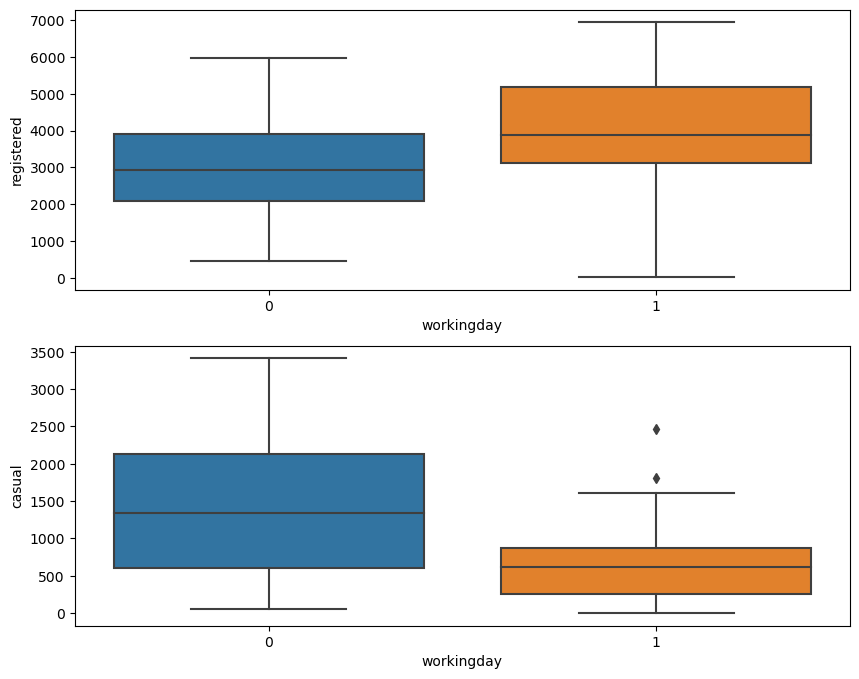

In [47]:
# weekday and workingday both try to convey same pattern that causal usage is higher on weekend and registered 
# usage is higher on working day
fig,axes = plt.subplots(2,1)
fig.set_size_inches(10,8)
sns.boxplot(x=data["workingday"],y=data["registered"], ax=axes[0])
sns.boxplot(x=data["workingday"],y=data["casual"], ax=axes[1])
plt.show()

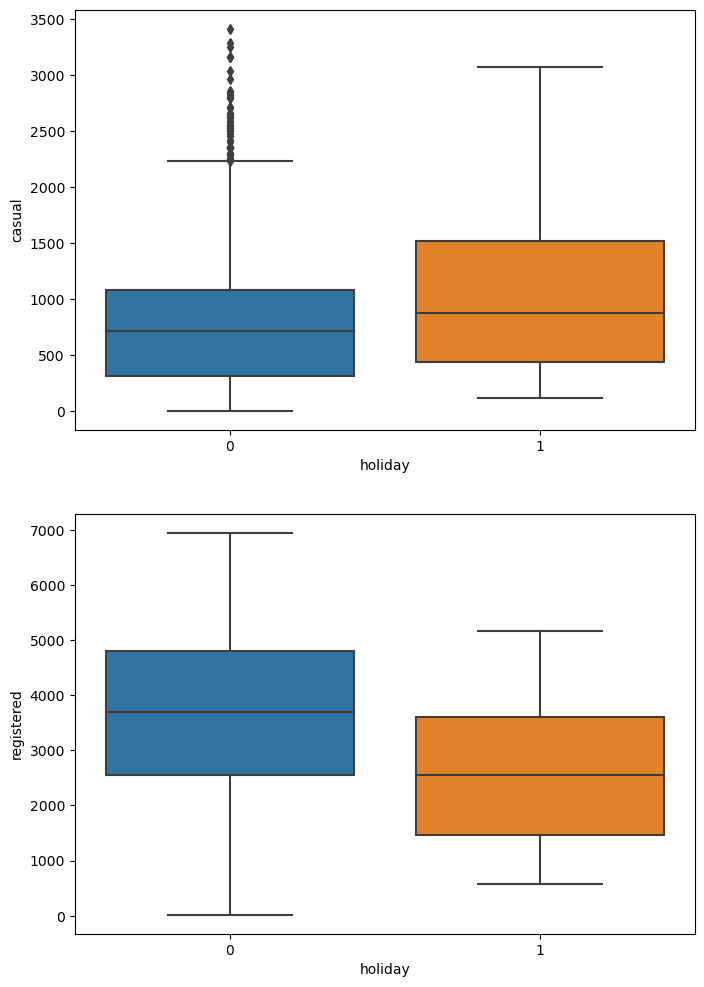

In [48]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(8, 12)
sns.boxplot(x=data["holiday"],y=data["casual"], ax=axes[0])
sns.boxplot(x=data["holiday"],y=data["registered"], ax=axes[1])
plt.show()
# similar pattern is also visible on holidays where casual usage is higher and registered usage drops

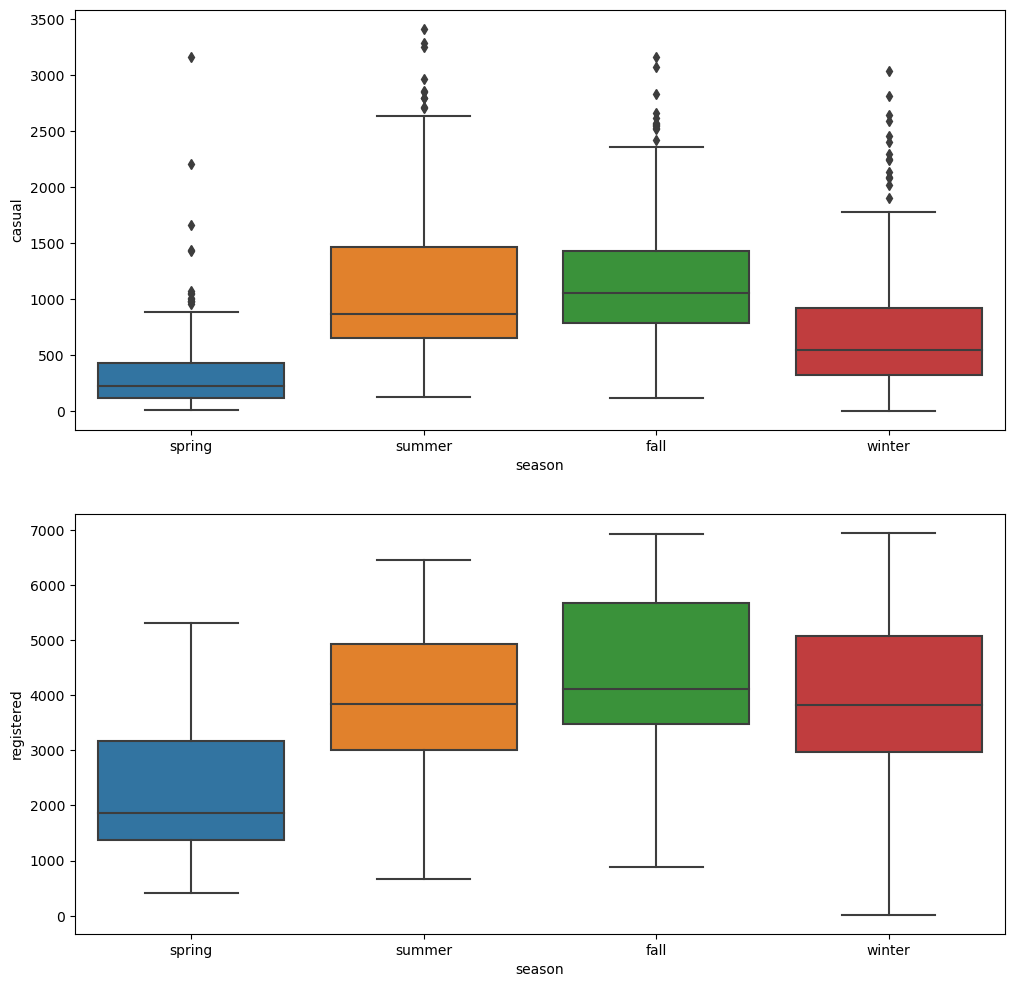

In [49]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(12, 12)
sns.boxplot(x=data["season"],y=data["casual"], ax=axes[0])
sns.boxplot(x=data["season"],y=data["registered"], ax=axes[1])
plt.show()

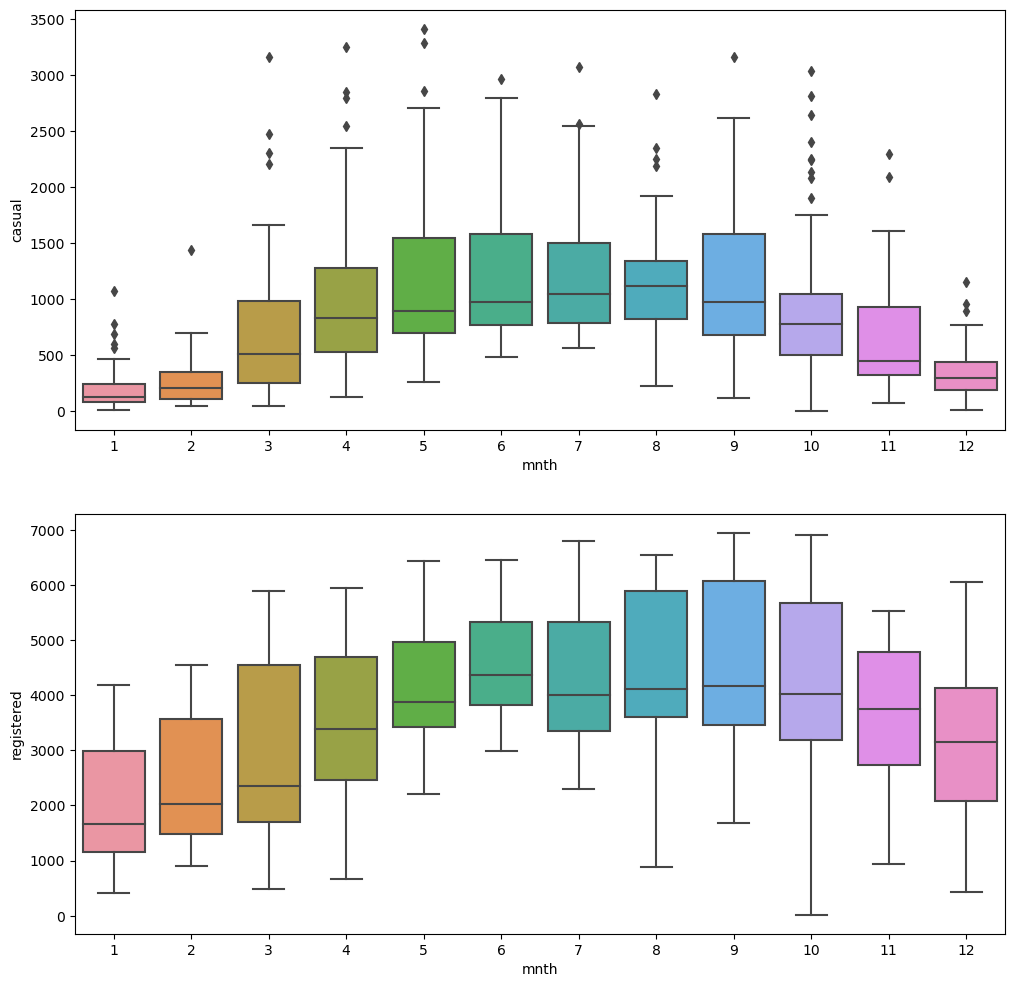

In [50]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(12, 12)
sns.boxplot(x=data["mnth"],y=data["casual"], ax=axes[0])
sns.boxplot(x=data["mnth"],y=data["registered"], ax=axes[1])
plt.show()
# we can see from month 4 to 9 there is visible increase for casual usage and slight increase for registered usage
# it can be seen that different month might have different usage/growth due to season/school holidays/festivals etc. 


In [51]:
# Data Preparation
# Remove redundant variables
data_prep = data.drop(["instant","dteday","casual","registered","atemp"],axis=1)
# create dummy variables for categorical varaible
data_prep.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,2018,1,0,6,0,Mist,14.110847,80.5833,10.749882,985
1,spring,2018,1,0,0,0,Mist,14.902598,69.6087,16.652113,801
2,spring,2018,1,0,1,1,clear,8.050924,43.7273,16.636703,1349
3,spring,2018,1,0,2,1,clear,8.200000,59.0435,10.739832,1562
4,spring,2018,1,0,3,1,clear,9.305237,43.6957,12.522300,1600


In [52]:
data_prep['season']=data_prep['season'].astype('category')
data_prep['weathersit']=data_prep['weathersit'].astype('category')
data_prep['mnth']=data_prep['mnth'].astype('category')
data_prep['weekday']=data_prep['weekday'].astype('category')

In [53]:
data_prep = pd.get_dummies(data_prep, dtype=int, drop_first=True)
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   yr                730 non-null    int64  
 1   holiday           730 non-null    int64  
 2   workingday        730 non-null    int64  
 3   temp              730 non-null    float64
 4   hum               730 non-null    float64
 5   windspeed         730 non-null    float64
 6   cnt               730 non-null    int64  
 7   season_spring     730 non-null    int32  
 8   season_summer     730 non-null    int32  
 9   season_winter     730 non-null    int32  
 10  mnth_2            730 non-null    int32  
 11  mnth_3            730 non-null    int32  
 12  mnth_4            730 non-null    int32  
 13  mnth_5            730 non-null    int32  
 14  mnth_6            730 non-null    int32  
 15  mnth_7            730 non-null    int32  
 16  mnth_8            730 non-null    int32  
 1

In [54]:
# Splitting dataset into train and test datasets

data_train, data_test = train_test_split(data_prep, train_size = 0.7, test_size=0.3, random_state=100 )

In [55]:
# scaling the numeric features (except dummy variables)

scaler = StandardScaler()
data_train[["temp","hum","windspeed","cnt"]] = scaler.fit_transform(data_train[["temp","hum","windspeed","cnt"]])

In [56]:
y_train = data_train.pop("cnt")
X_train = data_train

In [57]:
# feature selection
# let's first use RFE to do coarse grain feature selection
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(estimator = lm,n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'season_spring', 'season_winter',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_8', 'mnth_9', 'weekday_6',
       'weathersit_Mist', 'weathersit_clear'],
      dtype='object')

In [58]:
X_train_rfe = X_train[col]

In [59]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [60]:
lm = sm.OLS(y_train, X_train_rfe).fit()

In [61]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     163.1
Date:                Wed, 31 Jul 2024   Prob (F-statistic):          2.92e-180
Time:                        13:00:39   Log-Likelihood:                -268.81
No. Observations:                 510   AIC:                             569.6
Df Residuals:                     494   BIC:                             637.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2105.1947     75.512  

In [62]:
# P-Value for all the variables are very low, meaning all the variables are significant in explaining target variable
# Adj R2 is 0.827 which means model is able to explain target variable well with predictor variables
# prob(F-stat) is very low here (~0) < 0.05, which means it also explains variance well

In [63]:
# Redisual Analysis
y_train_pred = lm.predict(X_train_rfe)

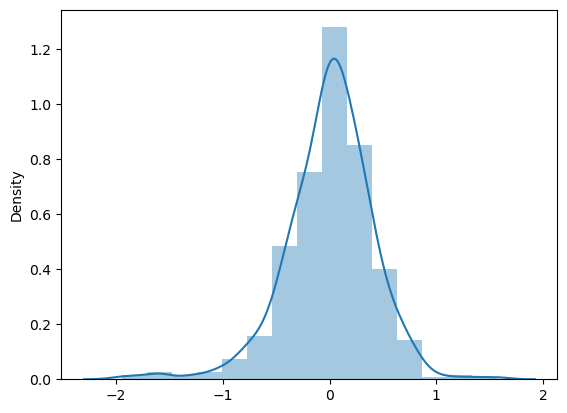

In [64]:
sns.distplot((y_train - y_train_pred), bins=15)
plt.show()
# Error mean is centered around 0 and following normal distribution

In [65]:
# Now lets apply this model on test dataset
data_test[["temp","hum","windspeed","cnt"]] = scaler.fit_transform(data_test[["temp","hum","windspeed","cnt"]])

y_test = data_test.pop("cnt")
X_test = sm.add_constant(data_test[col])
y_test_pred = lm.predict(X_test)


In [66]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     163.1
Date:                Wed, 31 Jul 2024   Prob (F-statistic):          2.92e-180
Time:                        13:00:39   Log-Likelihood:                -268.81
No. Observations:                 510   AIC:                             569.6
Df Residuals:                     494   BIC:                             637.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2105.1947     75.512    -27.879      0.000   -2253.559   -1956.831
yr                   1.0422      0.037     27.855      0.000       0.969       1.116
holiday             -0.2324      0.126     -1.841      0.066      -0.480       0.016
workingday           0.2050      0.054      3.798      0.000       0.099       0.311
temp                 0.4445      0.033     13.478      0.000       0.380       0.509
season_spring       -0.3394      0.087     -3.913      0.000      -0.510      -0.169
season_winter        0.4717      0.075      6.294      0.000       0.324       0.619
mnth_3               0.2297      0.069      3.317      0.001       0.094       0.366
mnth_4               0.2357      0.092      2.573      0.010       0.056       0.416
mnth_5               0.3715      0.085      4.353      0.000       0.204       0.539
mnth_6               0.2490      0.088      2.817      0.005       0.075       0.423
mnth_8               0.2173      0.083      2.611      0.009       0.054       0.381
mnth_9               0.5014      0.080      6.288      0.000       0.345       0.658
weekday_6            0.2433      0.068      3.582      0.000       0.110       0.377
weathersit_Mist      0.9889      0.113      8.716      0.000       0.766       1.212
weathersit_clear     1.3537      0.112     12.114      0.000       1.134       1.573
==============================================================================
Omnibus:                       76.654   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.003
Skew:                          -0.715   Prob(JB):                     2.28e-49
Kurtosis:                       5.915   Cond. No.                     8.26e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.26e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)

0.8146324110061646

In [68]:
#here r2 score on test data is very close r2 score on train data, so model built is also applying well on test data.